In [8]:
# AIM OF THIS NOTE BOOK

## optional - download dataset
# https://cs.stanford.edu/~acoates/stl10/
# wget https://raw.githubusercontent.com/mttk/STL10/master/stl10_input.py
# python stl10_input.py

## generate random lines

## overlay lines to images

## train yolo with images with line

In [9]:
SEED = 0
import os
import random as rn
import numpy as np
from tensorflow import set_random_seed

os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
set_random_seed(SEED)
rn.seed(SEED)

In [209]:
%load_ext autoreload
%autoreload 2

import traceback
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from make_line import make_data, get_grid

In [21]:
# x  (None,64,64)
# y0 (None,64,5)     - object,relstartx,relstarty,shapex,shapey
# y1 (None,64,64,64) - 64x(64,64) mask

szx,szy,szz=64,64,64
smx,smy=8,8
x_train, y_train0, y_train1 = make_data(N=1024)
x_val, y_val0, y_val1 = make_data(N=100)
x_test, y_test0, y_test1 = make_data(N=5)
grid, grid_anchor = get_grid()

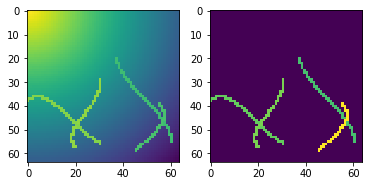

In [31]:
ind = -3
plt.subplot(121)
plt.imshow(x_train[ind,:].squeeze())
region = np.argwhere(y_train0[ind,:,-1]==1)
tmp = np.zeros((szx,szy))
if len(region.squeeze().shape) > 0:
    for r in region.squeeze():
        tmp[y_train1[ind,r,:,:].squeeze()==1]=r+1
plt.subplot(122)
plt.imshow(tmp)

In [32]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)

from keras.models import Sequential, load_model
from keras import optimizers as opt
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Reshape, Conv2DTranspose
from keras.callbacks import LearningRateScheduler,EarlyStopping

from keras.models import Model
from keras.layers import Permute, Reshape, Lambda, add, Input, Concatenate
from keras.layers import Conv2D, BatchNormalization, LeakyReLU
from keras import regularizers, initializers


In [253]:
def viz_results(x_test,y_test0,ytest1,pred,szx,szy):
    obj_ind = -1
    #for ind in range(pred.shape[0]):
    for ind in range(5):

        plt.figure(ind,figsize=(20,10))
        
        argmax = np.argmax(pred[0][ind,:,obj_ind].squeeze())
        
        print(argmax,'pred',pred[0][ind,argmax,:])
        print(argmax,'true',y_test0[ind,argmax,:])
        print('------')
        
        # GROUND TRUTH
        sa=plt.subplot(331)
        plt.title('sample index: {}, t:green, p:blue'.format(ind))
        sa.imshow(x_test[ind,:].squeeze())
        
        # overlay bounding box
        ax,ay=grid_anchor[argmax]
        x,y,w,h,o = pred[0][ind,argmax,:]
        x,y,w,h,o = x*szx,y*szy,w*szx,h*szy,o
        x,y = ax+x,ay+y
        x,y = x-w/2.,y-h/2.
        rect = patches.Rectangle((y,x),h,w,linewidth=2,edgecolor='b',facecolor='none')
        sa.add_patch(rect)
        
        x,y,w,h,o = y_test0[ind,argmax,:]
        x,y,w,h,o = x*szx,y*szy,w*szx,h*szy,o
        x,y = ax+x,ay+y
        x,y = x-w/2.,y-h/2.
        rect = patches.Rectangle((y,x),h,w,linewidth=2,edgecolor='g',facecolor='none')
        sa.add_patch(rect)
        
        region = np.argwhere(y_test0[ind,:,obj_ind]==1).ravel()
        obj_real = np.zeros((szx,szy))
        for r in region:
            obj_real[grid==r]=1
        obj_real = np.reshape(y_test0[ind,:,obj_ind],(smx,smy))
        
        plt.subplot(332)
        plt.title('obj or not - truth'.format())
        plt.imshow(obj_real,cmap='gray')
        obj = np.reshape(pred[0][ind,:,obj_ind],(smx,smy))

        ax = plt.subplot(333)
        plt.title('obj or not - truth - actual val'.format())
        plt.plot(y_test0[ind,:,obj_ind])
        ax.set_ylim(0,1)

        # PREDICTED
        plt.subplot(334)
        plt.title('obj or not - pred'.format())
        plt.imshow(obj,cmap='gray')
        plt.subplot(335)
        plt.title('obj or not - pred - actual val'.format())
        plt.imshow(obj,vmin=0,vmax=1,cmap='gray')
        
        ax = plt.subplot(336)
        plt.title('obj or not - pred - actual val'.format())
        plt.plot(pred[0][ind,:,obj_ind])
        ax.set_ylim(0,1)

        if len(pred)>1:
            plt.subplot(337)
            plt.title('mask - pred'.format())
            
            plt.title('argmax {}'.format(argmax))
            plt.imshow(pred[1][ind,argmax,:,:].squeeze(),cmap='gray')

In [222]:

os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
set_random_seed(SEED)
rn.seed(SEED)

# simple yolo
#   https://gist.github.com/msrks/ce613e91a98868d4a059c6c5c5e30ba3
# vanillay conv cannot prediction coord
#   https://eng.uber.com/coordconv/
# alternative archetectures.
#   https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e
#   https://github.com/jianing-sun/Mask-YOLO
# actual yolos
#   https://github.com/ksanjeevan/dourflow/blob/master/net/netarch.py
#   https://github.com/guigzzz/Keras-Yolo-v2


epsilon = 1E-8
def compute_obj_loss(y_true,y_pred):
    return tf.keras.backend.binary_crossentropy(y_true[...,-1], y_pred[...,-1])

def compute_coord_loss(y_true,y_pred):
    loss_px = tf.squared_difference(y_true[...,0], y_pred[...,0])
    loss_py = tf.squared_difference(y_true[...,1], y_pred[...,1])
    loss_wx = tf.squared_difference(y_true[...,2], y_pred[...,2])
    loss_wy = tf.squared_difference(y_true[...,3], y_pred[...,3])
    
    loss_pos = tf.add(loss_px,loss_py)
    loss_width = tf.add(loss_wx,loss_wy)
    
    coord_loss = tf.add(loss_pos,loss_width)
    coord_loss = tf.multiply(y_true[...,-1],coord_loss)
    return coord_loss

def compute_iou_loss(y_true,y_pred):
    # ref. https://github.com/ksanjeevan/dourflow/blob/master/net/netloss.py
    def process_boxes(A):
        # ALign x-w, y-h
        A_xy = A[..., 0:2]
        A_wh = A[..., 2:4]
        
        A_wh_half = A_wh / 2.
        # Get x_min, y_min
        A_mins = A_xy - A_wh_half
        # Get x_max, y_max
        A_maxes = A_xy + A_wh_half
        
        return A_mins, A_maxes, A_wh
    
    # Process two sets
    A2_mins, A2_maxes, A2_wh = process_boxes(y_pred)
    A1_mins, A1_maxes, A1_wh = process_boxes(y_true)
    
    # Intersection as min(Upper1, Upper2) - max(Lower1, Lower2)
    intersect_mins  = K.maximum(A2_mins,  A1_mins)
    intersect_maxes = K.minimum(A2_maxes, A1_maxes)
    
    # Getting the intersections in the xy (aka the width, height intersection)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)

    # Multiply to get intersecting area
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    # Values for the single sets
    true_areas = A1_wh[..., 0] * A1_wh[..., 1]
    pred_areas = A2_wh[..., 0] * A2_wh[..., 1]
    
    # Compute union for the IoU
    union_areas = pred_areas + true_areas - intersect_areas
    
    # probably not necssary...
    iou_loss = tf.multiply(y_true[...,-1], tf.truediv(intersect_areas,(union_areas+epsilon)) )
    
    return iou_loss

def vec_loss(y_true, y_pred):
    
    lambda_obj = 1.0
    lambda_coord = 1.0
    lambda_iou = 1.0
    
    obj_loss = compute_obj_loss(y_true, y_pred)
    obj_loss = tf.multiply(lambda_obj,obj_loss)
    
    coord_loss = compute_coord_loss(y_true, y_pred)
    coord_loss = tf.multiply(lambda_coord,coord_loss)
    
    iou_loss = compute_iou_loss(y_true, y_pred)
    iou_loss = tf.multiply(lambda_iou,iou_loss)
    
    total_loss = tf.add(tf.add(obj_loss,coord_loss),iou_loss)
    
    return tf.reduce_mean(total_loss)


def conv_batch_lrelu(input_tensor, numfilter, dim, strides=2):
    # https://github.com/guigzzz/Keras-Yolo-v2/blob/f61286371cdc2d470e0811234f552c70bbd5caba/yolo_layer_utils.py#L18
    input_tensor = Conv2D(numfilter, (dim, dim), strides=strides, padding='same',
                        kernel_regularizer=regularizers.l2(0.0005),
                        kernel_initializer=initializers.TruncatedNormal(stddev=0.1),
                        use_bias=False
                    )(input_tensor)
    input_tensor = BatchNormalization()(input_tensor)
    return LeakyReLU(alpha=0.1)(input_tensor)

def convt_batch_lrelu(input_tensor, numfilter, dim, strides=2):
    input_tensor = Conv2DTranspose(numfilter, (dim, dim), strides=strides, padding='same',
                        kernel_regularizer=regularizers.l2(0.0005),
                        kernel_initializer=initializers.TruncatedNormal(stddev=0.1),
                        use_bias=False
                    )(input_tensor)
    input_tensor = BatchNormalization()(input_tensor)
    return LeakyReLU(alpha=0.1)(input_tensor)

MASK = 'MASK'
VECTOR = 'VECTOR'

inputs = Input(shape=(szx,szy,1))

dropoutrate = 0.2
# down sample
xd = conv_batch_lrelu(inputs, 32, 3)
xd=Dropout(dropoutrate)(xd)
xd = conv_batch_lrelu(xd, 64, 3)
xd=Dropout(dropoutrate)(xd)
xd = conv_batch_lrelu(xd, 128, 3)
xd=Dropout(dropoutrate)(xd)
xd = conv_batch_lrelu(xd, 256, 3)
xd=Dropout(dropoutrate)(xd)

# bottle neck
x=Flatten()(xd)
x=Dense(128,
    kernel_regularizer=regularizers.l2(0.0005),
    kernel_initializer=initializers.TruncatedNormal(stddev=0.1),
    use_bias=False,
    )(x) # # filter size ratio between conv and dense needs to be tuned!
x=BatchNormalization()(x)
x=LeakyReLU(alpha=0.1)(x)
x=Dropout(dropoutrate)(x)
x=Dense(128,
    kernel_regularizer=regularizers.l2(0.0005),
    kernel_initializer=initializers.TruncatedNormal(stddev=0.1),
    use_bias=False,
    )(x)
x=BatchNormalization()(x)
x=LeakyReLU(alpha=0.1)(x)
x=Dropout(dropoutrate)(x) # attempt to prevent overfit...
x=Dense(smx*smy*5,
    kernel_regularizer=regularizers.l2(0.0005),
    kernel_initializer=initializers.TruncatedNormal(stddev=0.1),
    use_bias=True,
    )(x)
x=Reshape((smx*smy,5))(x)

# output split - split output to have varying activations for pos,width, and obj
# output: pos and width
x_pos_width = Lambda(lambda x: x[..., 0:4])(x)
x_pos_width=Activation('sigmoid')(x_pos_width)
#x_pos_width=Activation('linear')(x_pos_width)
#x_pos_width=Lambda(lambda x: K.clip(x,0.,1.))(x_pos_width)

# output: sigmoid
x_obj = Lambda(lambda x: K.expand_dims(x[..., -1],axis=-1))(x)
x_obj=Activation('sigmoid')(x_obj)

# merge outputs
vecs = Concatenate(axis=-1,name=VECTOR)([x_pos_width,x_obj])
model = Model(inputs=inputs, outputs=vecs)
model.summary()
print(x_train.shape,y_train0.shape,y_train1.shape)


# very nice ref. https://github.com/ksanjeevan/dourflow/blob/master/yolov2.py
# opt.Adam, opt.RMSprop
verbose=1
batch_size=32
epochs=1000
lr=1E-3
decay=1E-4
patience=10
beta_1=0.9
beta_2=0.999

early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=patience,
                              verbose=0,
                              mode='min')
callbacks = [early_stopping]

optimizer = opt.Adam(lr=lr,beta_1=beta_1, beta_2=beta_2, decay=decay)
model.compile(loss=vec_loss, optimizer=optimizer)
history = model.fit(x_train, y_train0,
                    batch_size=batch_size, epochs=epochs,
                    verbose=verbose, 
                    validation_data=(x_val, y_val0),
                    callbacks=callbacks)




__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_129 (Conv2D)             (None, 32, 32, 32)   288         input_33[0][0]                   
__________________________________________________________________________________________________
batch_normalization_193 (BatchN (None, 32, 32, 32)   128         conv2d_129[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_193 (LeakyReLU)     (None, 32, 32, 32)   0           batch_normalization_193[0][0]    
__________________________________________________________________________________________________
dropout_17

dict_keys(['val_loss', 'loss'])

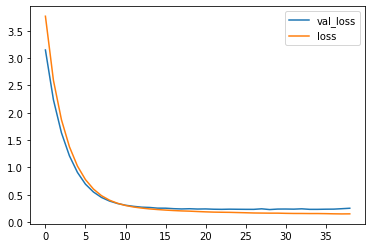

In [223]:
df = pd.DataFrame(history.history)
df.plot()
history.history.keys()

In [269]:
x_0, y_0, y_1 = x_train, y_train0, y_train1
out = model.evaluate(x_0,y_0)
print('train',out)
x_0, y_0, y_1 = x_val, y_val0, y_val1
out = model.evaluate(x_0,y_0)
print('val',out)
x_0, y_0, y_1 = x_test, y_test0, y_test1
out = model.evaluate(x_0,y_0)
print('test',out)

1024/1024 [==============================] - 0s 231us/step
train 0.16056572273373604
100/100 [==============================] - 0s 271us/step
val 0.2517317736148834
5/5 [==============================] - 0s 1ms/step
test 0.2758445739746094


20 pred [0.40733832 0.11630279 0.30260354 0.48699212 0.9739591 ]
20 true [0.0390625 0.03125   0.578125  0.65625   1.       ]
------
28 pred [0.19440407 0.45184943 0.60104614 0.40384597 0.93658423]
28 true [0.1171875 0.0078125 0.984375  0.390625  1.       ]
------
37 pred [0.1091893  0.3846936  0.53674537 0.2846995  0.95049834]
37 true [0.0546875 0.03125   0.234375  0.375     1.       ]
------
30 pred [0.15636781 0.32774645 0.5576054  0.22178867 0.5825824 ]
30 true [0.0390625 0.0703125 0.703125  0.265625  1.       ]
------
28 pred [0.19409993 0.43030453 0.60887873 0.48152927 0.9406842 ]
28 true [0.0703125 0.0078125 0.421875  0.953125  1.       ]
------


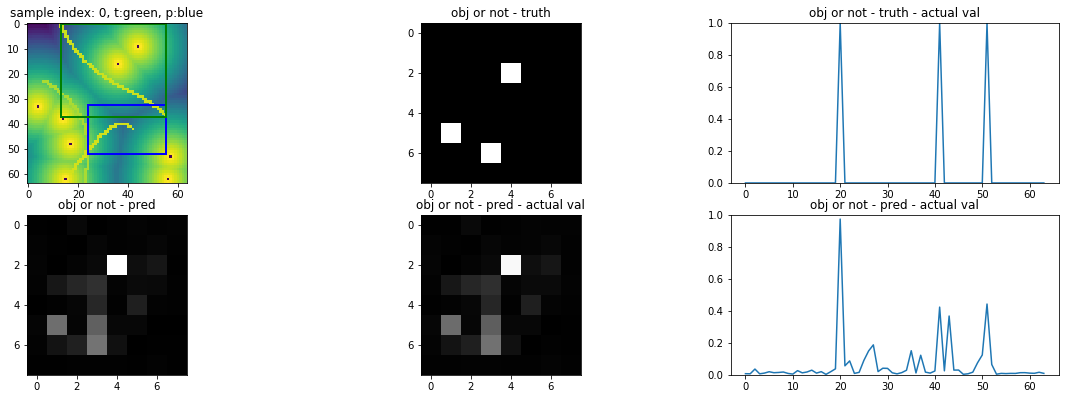

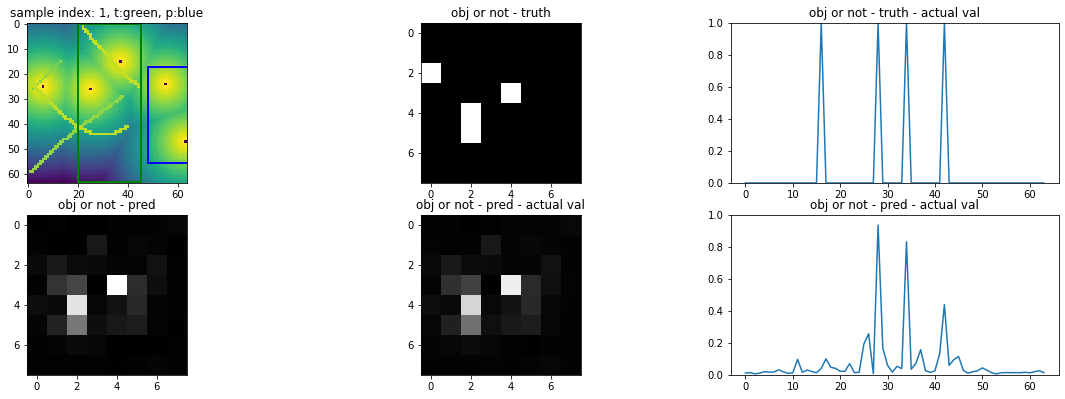

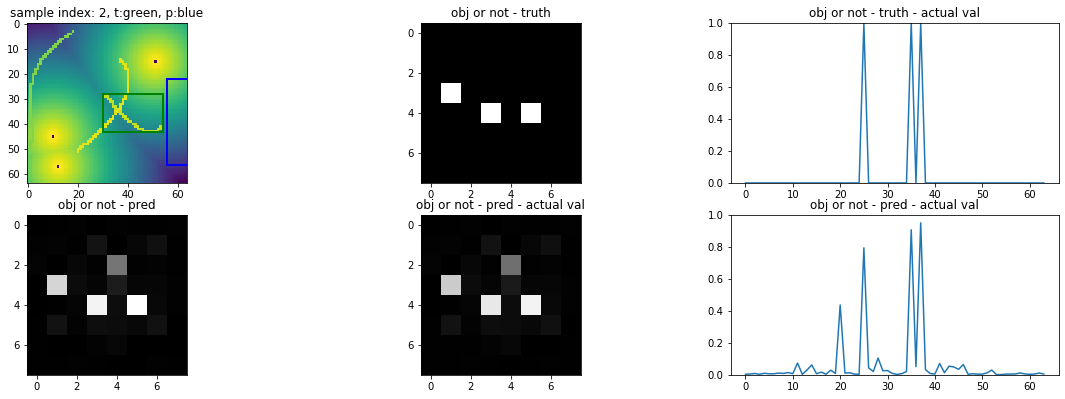

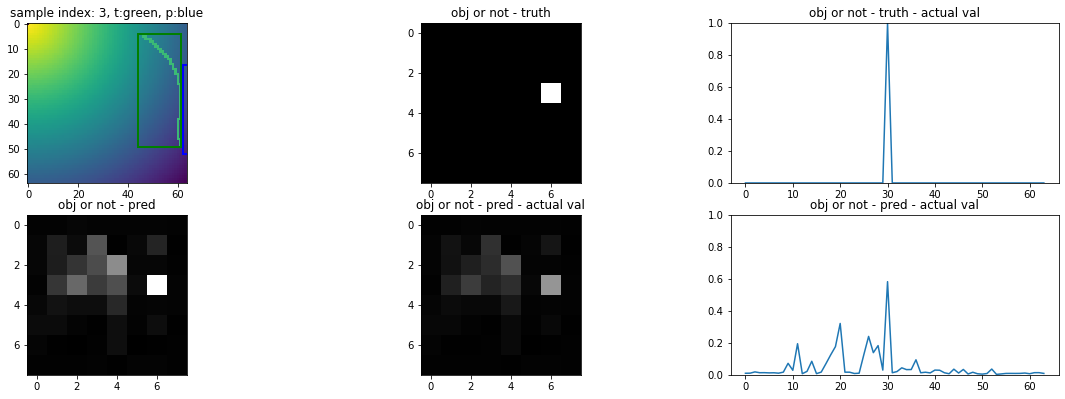

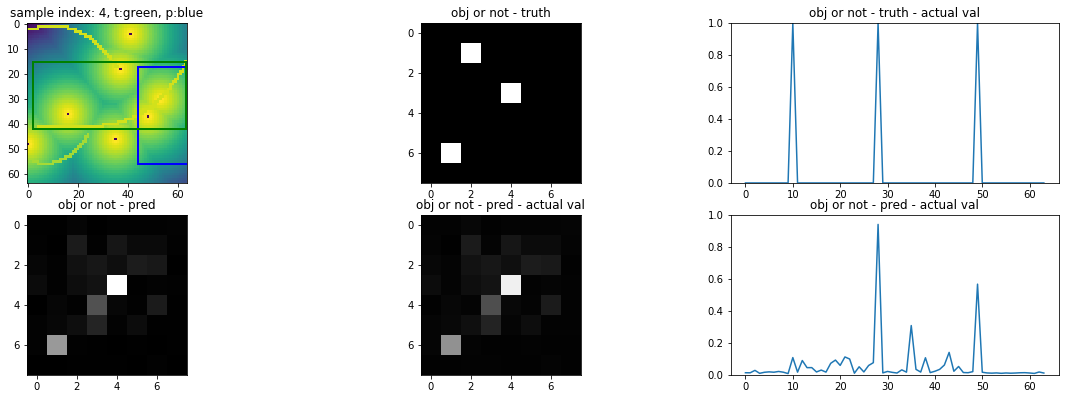

In [271]:
#x_0, y_0, y_1 = x_test, y_test0, y_test1
x_0, y_0, y_1 = x_train, y_train0, y_train1
#x_0, y_0, y_1 = x_val, y_val0, y_val1
pred = model.predict(x_0)
pred = [pred]
viz_results(x_0,y_0,y_1,pred,szx,szy)

In [ ]:
# !CUDA_VISIBLE_DEVICES=0 python line-yolo-hyper-param-search.py

In [272]:
from keras.models import load_model

best_model = load_model(
    'line-yolo-model.h5',
   custom_objects={
       'vec_loss':vec_loss,
       'compute_iou_loss':compute_iou_loss,
       'compute_coord_loss':compute_coord_loss,
       'compute_obj_loss':compute_obj_loss,
   },
)

1024/1024 [==============================] - 0s 228us/step
train 0.30193229485303164
100/100 [==============================] - 0s 287us/step
val 0.30184446096420287
5/5 [==============================] - 0s 1ms/step
test 0.3006790578365326
27 pred [0.57164896 0.28218776 0.46000776 0.5729024  0.24804726]
27 true [0. 0. 0. 0. 0.]
------
27 pred [0.5185155  0.34085822 0.46613607 0.56592727 0.2749858 ]
27 true [0. 0. 0. 0. 0.]
------
27 pred [0.55838895 0.285415   0.45506555 0.58092606 0.25317365]
27 true [0. 0. 0. 0. 0.]
------
27 pred [0.5090859  0.3691774  0.47709355 0.53202903 0.2728127 ]
27 true [0. 0. 0. 0. 0.]
------
27 pred [0.51916736 0.326966   0.46561253 0.5534157  0.268106  ]
27 true [0. 0. 0. 0. 0.]
------


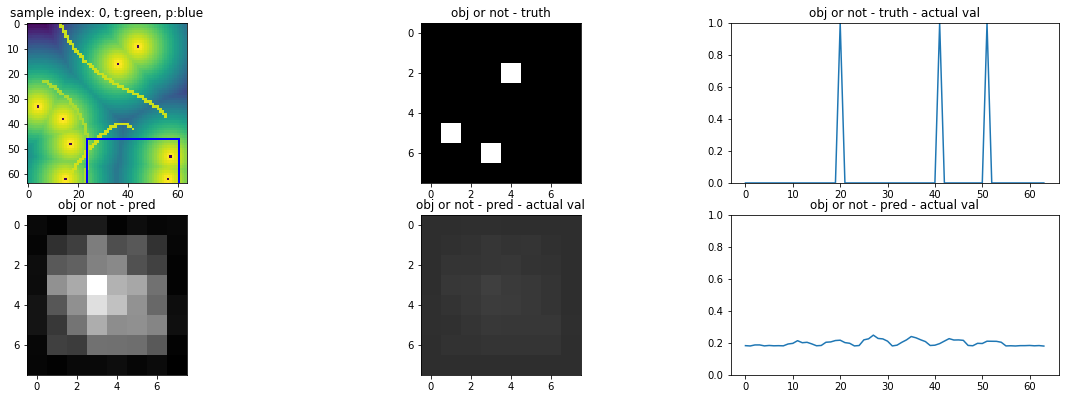

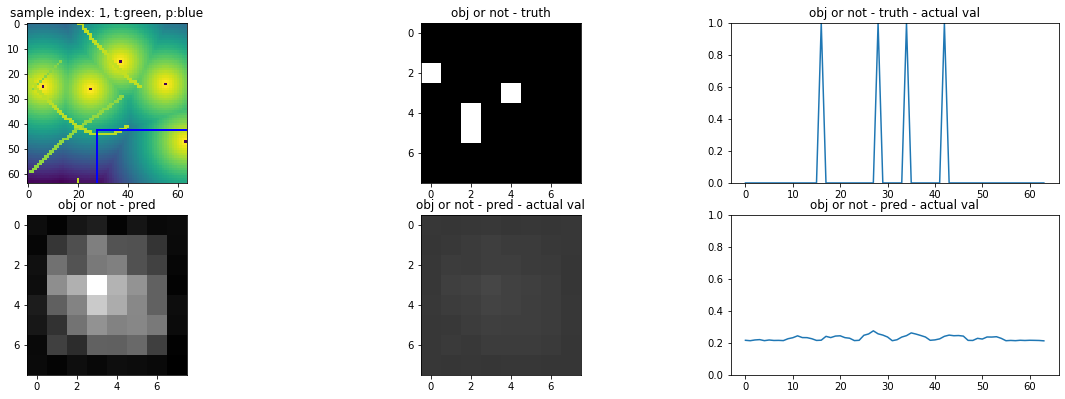

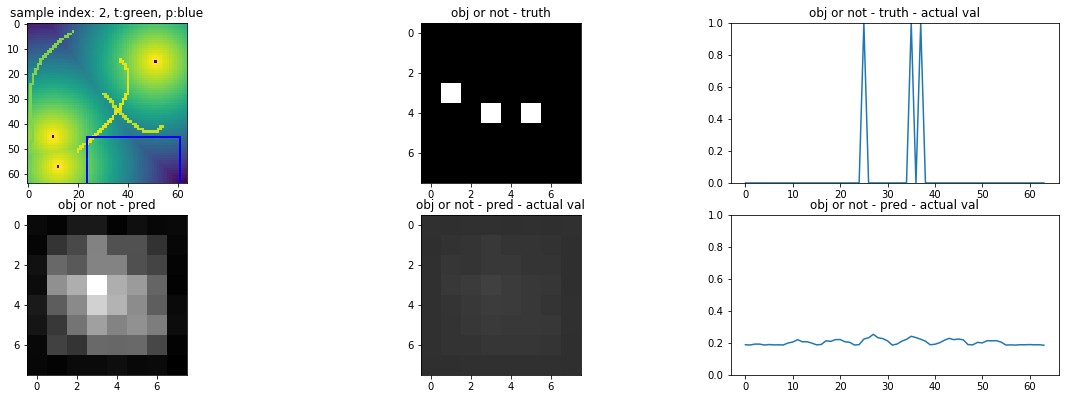

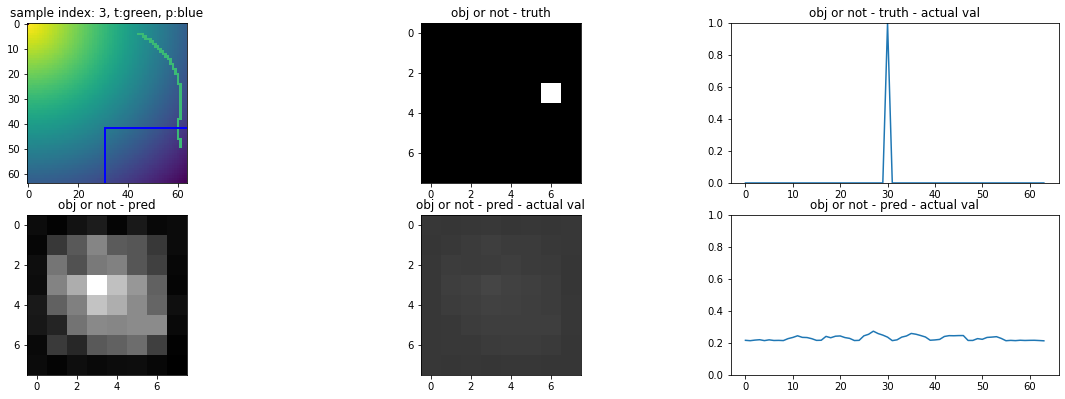

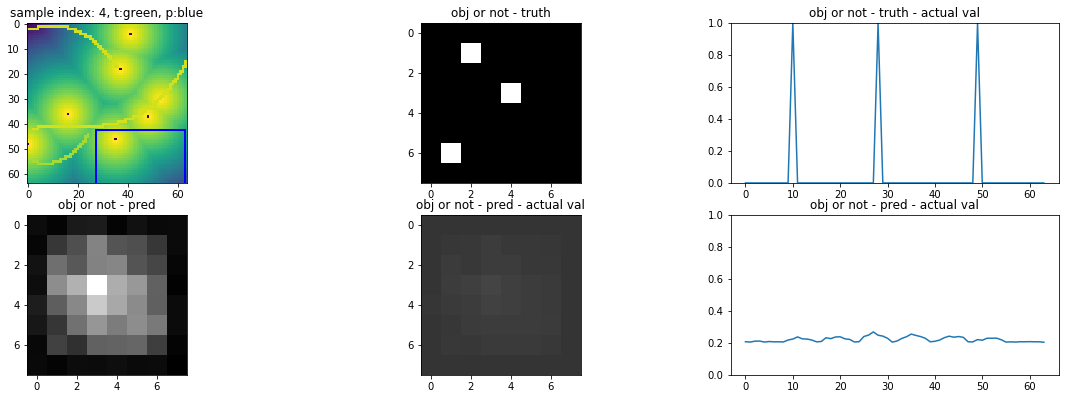

In [289]:
x_0, y_0, y_1 = x_train, y_train0, y_train1
out = best_model.evaluate(x_0,y_0)
print('train',out)
x_0, y_0, y_1 = x_val, y_val0, y_val1
out = best_model.evaluate(x_0,y_0)
print('val',out)
x_0, y_0, y_1 = x_test, y_test0, y_test1
out = best_model.evaluate(x_0,y_0)
print('test',out)

x_0, y_0, y_1 = x_train, y_train0, y_train1
pred = best_model.predict(x_0)
viz_results(x_0,y_0,y_1,[pred],szx,szy)